# Classification of text documents: 20-Newsgroup Dataset

(From http://scikit-learn.org/stable/auto_examples/text/mlcomp_sparse_document_classification.html#sphx-glr-auto-examples-text-mlcomp-sparse-document-classification-py)

This is an example showing how the scikit-learn can be used to classify documents by topics using a bag-of-words approach. 
This example uses a scipy.sparse matrix to store the features instead of standard numpy arrays.

The dataset used in this example is the <b>20 newsgroups dataset</b> and should be downloaded from the http://mlcomp.org (free registration required): http://mlcomp.org/datasets/379

Once downloaded unzip the archive somewhere on your filesystem. For instance in:

```
% mkdir -p ~/data/mlcomp
% cd  ~/data/mlcomp
% unzip /path/to/dataset-379-20news-18828_XXXXX.zip
```

You should get a folder ~/data/mlcomp/379 with a file named metadata and subfolders raw, train and test holding the text documents organized by newsgroups.

Then set the MLCOMP_DATASETS_HOME environment variable pointing to the root folder holding the uncompressed archive:
```
% export MLCOMP_DATASETS_HOME="~/data/mlcomp"
```

Alternatively, you can execute this code (assuming the Data folder is located under the folder in which your notebook is running):

In [6]:
import os
os.environ['MLCOMP_DATASETS_HOME']='Data/mlcomp'

The statistics of the dataset are:

```
20 newsgroups dataset for document classification 
Source: http://people.csail.mit.edu/jrennie/20Newsgroups
Format: DocumentClassification
User:   pliang
Size:   64M
#train  13180
#test   5648
#labels 20
```

In [24]:
# Author: Olivier Grisel <olivier.grisel@ensta.org>
# License: BSD 3 clause

%matplotlib inline

from __future__ import print_function

from time import time
import sys
import os
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

from sklearn.datasets import load_mlcomp
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB

SKLearn has built-in utilities to load datasets from the MLCOMP repository.

In [8]:
# Load the training set
print("Loading 20 newsgroups training set... ")
news_train = load_mlcomp('20news-18828', 'train')
print(news_train.DESCR)
print("%d documents" % len(news_train.filenames))
print("%d categories" % len(news_train.target_names))

Loading 20 newsgroups training set... 
20 newsgroups dataset for document classification (http://people.csail.mit.edu/jrennie/20Newsgroups)
13180 documents
20 categories


We now vectorize the dataset using SKLearn vectorizers.  This is the stage of feature extraction.
We use the TF-IDF feature model.

In [15]:
print("Extracting features from the dataset using a sparse vectorizer")
t0 = time()
vectorizer = TfidfVectorizer(encoding='latin1')
X_train = vectorizer.fit_transform((open(f, encoding='latin1').read() for f in news_train.filenames))
print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X_train.shape)
assert sp.issparse(X_train)
y_train = news_train.target

Extracting features from the dataset using a sparse vectorizer
done in 156.359400s
n_samples: 13180, n_features: 130274


Let us load the test dataset:

In [16]:
print("Loading 20 newsgroups test set... ")
news_test = load_mlcomp('20news-18828', 'test')
t0 = time()
print("done in %fs" % (time() - t0))

Loading 20 newsgroups test set... 
done in 0.000000s


In [19]:
print("Predicting the labels of the test set...")
print("%d documents" % len(news_test.filenames))
print("%d categories" % len(news_test.target_names))

Predicting the labels of the test set...
5648 documents
20 categories


We also extract features from the test dataset using the same vectorizer as for training:

In [21]:
print("Extracting features from the dataset using the same vectorizer")
t0 = time()
X_test = vectorizer.transform((open(f, encoding='latin1').read() for f in news_test.filenames))
y_test = news_test.target
print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X_test.shape)

Extracting features from the dataset using the same vectorizer
done in 3.270200s
n_samples: 5648, n_features: 130274


Let us now benchmark different classifiers:

In [22]:
def benchmark(clf_class, params, name):
    print("parameters:", params)
    t0 = time()
    clf = clf_class(**params).fit(X_train, y_train)
    print("done in %fs" % (time() - t0))

    if hasattr(clf, 'coef_'):
        print("Percentage of non zeros coef: %f" % (np.mean(clf.coef_ != 0) * 100))
    print("Predicting the outcomes of the testing set")
    t0 = time()
    pred = clf.predict(X_test)
    print("done in %fs" % (time() - t0))

    print("Classification report on test set for classifier:")
    print(clf)
    print()
    print(classification_report(y_test, pred, target_names=news_test.target_names))

    cm = confusion_matrix(y_test, pred)
    print("Confusion matrix:")
    print(cm)

    # Show confusion matrix
    plt.matshow(cm)
    plt.title('Confusion matrix of the %s classifier' % name)
    plt.colorbar()

   ## Benchmark a Linear Classifier

Testbenching a linear classifier...
parameters: {'n_iter': 50, 'penalty': 'l2', 'fit_intercept': True, 'alpha': 1e-05, 'loss': 'hinge'}
done in 11.101400s
Percentage of non zeros coef: 30.334948
Predicting the outcomes of the testing set
done in 0.062400s
Classification report on test set for classifier:
SGDClassifier(alpha=1e-05, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

                          precision    recall  f1-score   support

             alt.atheism       0.94      0.92      0.93       245
           comp.graphics       0.85      0.91      0.88       298
 comp.os.ms-windows.misc       0.88      0.88      0.88       292
comp.sys.ibm.pc.hardware       0.81      0.81      0.81       301
   comp.sys.mac.hardware       0.90      0.91      0.90       256


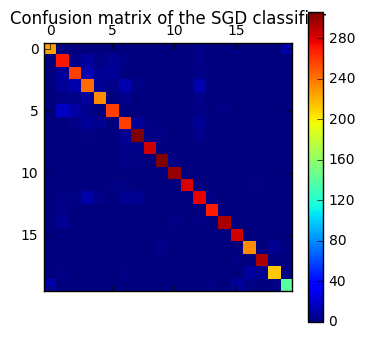

In [23]:
print("Testbenching a linear classifier...")
parameters = {
    'loss': 'hinge',
    'penalty': 'l2',
    'n_iter': 50,
    'alpha': 0.00001,
    'fit_intercept': True,
}

benchmark(SGDClassifier, parameters, 'SGD')

## Benchmark a MultinomialNB Classifier

Testbenching a MultinomialNB classifier...
parameters: {'alpha': 0.01}
done in 0.195400s
Percentage of non zeros coef: 100.000000
Predicting the outcomes of the testing set
done in 0.014000s
Classification report on test set for classifier:
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

                          precision    recall  f1-score   support

             alt.atheism       0.90      0.92      0.91       245
           comp.graphics       0.81      0.89      0.85       298
 comp.os.ms-windows.misc       0.87      0.83      0.85       292
comp.sys.ibm.pc.hardware       0.82      0.83      0.83       301
   comp.sys.mac.hardware       0.90      0.92      0.91       256
          comp.windows.x       0.90      0.89      0.89       297
            misc.forsale       0.90      0.84      0.87       290
               rec.autos       0.93      0.94      0.93       324
         rec.motorcycles       0.98      0.97      0.97       294
      rec.sport.baseball       0.97  

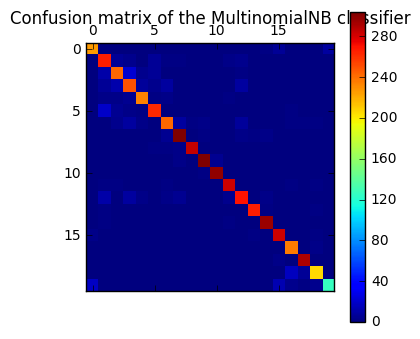

In [25]:
print("Testbenching a MultinomialNB classifier...")
parameters = {'alpha': 0.01}

benchmark(MultinomialNB, parameters, 'MultinomialNB')